In [50]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from plotnine import *

# Load the datasets
missing_tooth = pd.read_csv('missing_tooth.csv')
tooth_chipped = pd.read_csv('tooth_chipped_fault.csv')
surface_fault = pd.read_csv('surface_fault.csv')
no_fault = pd.read_csv('no_fault.csv')
root_crack = pd.read_csv('root_crack.csv')
eccentricity = pd.read_csv('eccentricity.csv')

In [51]:
no_fault.speedSet.value_counts()

speedSet
8.332031     50000
25.000000    50000
40.000000    50000
Name: count, dtype: int64

In [52]:
no_fault.load_value.value_counts()


load_value
0     75000
80    75000
Name: count, dtype: int64

In [53]:
missing_tooth['state'] = 'missing_tooth'
tooth_chipped['state'] = 'tooth_chipped'
surface_fault['state'] = 'surface_fault'
no_fault['state'] = 'no_fault'
root_crack['state'] = 'root_crack'
eccentricity['state'] = 'eccentricity'

df = pd.concat([
    missing_tooth, 
    tooth_chipped,
    surface_fault,
    no_fault,
    root_crack, 
    eccentricity
])
display(df.info())
#Normalize time_x grouped by state, load_value, speedSet
df['time_x'] = pd.to_datetime(df['time_x'])
df['time_normalized'] = df.groupby(['state', 'load_value', 'speedSet'])['time_x'].transform(lambda x: (x - x.min()).dt.total_seconds())

df['time_normalized']


<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sensor1          900000 non-null  float64
 1   sensor2          900000 non-null  float64
 2   time_x           900000 non-null  object 
 3   speedSet         900000 non-null  float64
 4   load_value       900000 non-null  int64  
 5   gear_fault_desc  900000 non-null  object 
 6   state            900000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 54.9+ MB


None

0         0.0000
1         0.0002
2         0.0004
3         0.0006
4         0.0008
           ...  
149995    4.9990
149996    4.9992
149997    4.9994
149998    4.9996
149999    4.9998
Name: time_normalized, Length: 900000, dtype: float64

In [54]:
df.drop(columns='time_normalized').describe()

,sensor1,sensor2,time_x,speedSet,load_value
count,900000.000000,900000.000000,900000,900000.000000,900000.000000
mean,2.519877,2.429291,2023-05-03 13:39:41.138789376,24.444010,40.000000
min,2.219428,2.161939,2023-05-02 10:30:01,8.332031,0.000000
25%,2.516895,2.426390,2023-05-02 16:02:08.249949952,8.332031,0.000000
50%,2.520180,2.429839,2023-05-03 13:54:29.499899904,25.000000,40.000000
75%,2.522972,2.432303,2023-05-03 20:28:31.249850112,40.000000,80.000000
max,2.820934,2.709896,2023-05-07 17:11:48.999800,40.000000,80.000000
std,0.011236,0.012001,NaN,12.934378,40.000022


In [55]:
df['time_formatted'] = pd.to_datetime(df.time_x, format="%Y-%m-%d %H:%M:%S.%f")

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   sensor1          900000 non-null  float64       
 1   sensor2          900000 non-null  float64       
 2   time_x           900000 non-null  datetime64[ns]
 3   speedSet         900000 non-null  float64       
 4   load_value       900000 non-null  int64         
 5   gear_fault_desc  900000 non-null  object        
 6   state            900000 non-null  object        
 7   time_normalized  900000 non-null  float64       
 8   time_formatted   900000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1), object(2)
memory usage: 68.7+ MB


In [57]:
df.state.value_counts()

state
missing_tooth    150000
tooth_chipped    150000
surface_fault    150000
no_fault         150000
root_crack       150000
eccentricity     150000
Name: count, dtype: int64

In [58]:
df.state.unique()

array(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault',
       'root_crack', 'eccentricity'], dtype=object)

In [59]:
df['no_fault'] = df.state == 'no_fault'

In [60]:
df.groupby('state')

In [61]:
df.columns

Index(['sensor1', 'sensor2', 'time_x', 'speedSet', 'load_value',
       'gear_fault_desc', 'state', 'time_normalized', 'time_formatted',
       'no_fault'],
      dtype='object')

In [62]:
df[[
    'speedSet', 
    'load_value',
    'sensor1', 
    'sensor2'
]].describe()

,speedSet,load_value,sensor1,sensor2
count,900000.000000,900000.000000,900000.000000,900000.000000
mean,24.444010,40.000000,2.519877,2.429291
std,12.934378,40.000022,0.011236,0.012001
min,8.332031,0.000000,2.219428,2.161939
25%,8.332031,0.000000,2.516895,2.426390
50%,25.000000,40.000000,2.520180,2.429839
75%,40.000000,80.000000,2.522972,2.432303
max,40.000000,80.000000,2.820934,2.709896


In [63]:
df.groupby(['speedSet', 'load_value', 'state']).sensor1.max()

speedSet   load_value  state        
8.332031   0           eccentricity     2.526914
                       missing_tooth    2.543340
                       no_fault         2.528393
                       root_crack       2.524615
                       surface_fault    2.575698
                       tooth_chipped    2.525436
           80          eccentricity     2.529542
                       missing_tooth    2.529871
                       no_fault         2.530364
                       root_crack       2.530035
                       surface_fault    2.580626
                       tooth_chipped    2.528721
25.000000  0           eccentricity     2.538576
                       missing_tooth    2.573399
                       no_fault         2.540383
                       root_crack       2.550403
                       surface_fault    2.820934
                       tooth_chipped    2.534963
           80          eccentricity     2.550403
                       missing_t

In [64]:
df.groupby(['speedSet', 'load_value', 'state']).sensor2.max()

speedSet   load_value  state        
8.332031   0           eccentricity     2.435259
                       missing_tooth    2.459734
                       no_fault         2.435259
                       root_crack       2.434274
                       surface_fault    2.466140
                       tooth_chipped    2.435259
           80          eccentricity     2.439366
                       missing_tooth    2.453163
                       no_fault         2.439202
                       root_crack       2.435588
                       surface_fault    2.455463
                       tooth_chipped    2.439530
25.000000  0           eccentricity     2.450042
                       missing_tooth    2.496691
                       no_fault         2.446922
                       root_crack       2.452178
                       surface_fault    2.538905
                       tooth_chipped    2.452835
           80          eccentricity     2.459898
                       missing_t

In [65]:
df.groupby('state').speedSet.describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
eccentricity,150000.0,24.44401,12.934413,8.332031,8.332031,25.0,40.0,40.0
missing_tooth,150000.0,24.44401,12.934413,8.332031,8.332031,25.0,40.0,40.0
no_fault,150000.0,24.44401,12.934413,8.332031,8.332031,25.0,40.0,40.0
root_crack,150000.0,24.44401,12.934413,8.332031,8.332031,25.0,40.0,40.0
surface_fault,150000.0,24.44401,12.934413,8.332031,8.332031,25.0,40.0,40.0
tooth_chipped,150000.0,24.44401,12.934413,8.332031,8.332031,25.0,40.0,40.0


In [66]:
df.groupby('state').load_value.describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
eccentricity,150000.0,40.0,40.000133,0.0,0.0,40.0,80.0,80.0
missing_tooth,150000.0,40.0,40.000133,0.0,0.0,40.0,80.0,80.0
no_fault,150000.0,40.0,40.000133,0.0,0.0,40.0,80.0,80.0
root_crack,150000.0,40.0,40.000133,0.0,0.0,40.0,80.0,80.0
surface_fault,150000.0,40.0,40.000133,0.0,0.0,40.0,80.0,80.0
tooth_chipped,150000.0,40.0,40.000133,0.0,0.0,40.0,80.0,80.0


In [67]:
#plot 

In [68]:
df['sensor1_max_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().max())
df['sensor1_min_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().min())

df['sensor2_max_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().max())
df['sensor2_min_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().min())

df['sensor1_mean_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
df['sensor2_mean_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())

df['sensor1_std_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().std())
df['sensor2_std_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().std())

c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 385 rows containing non-finite values.
c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 385 rows containing non-finite values.


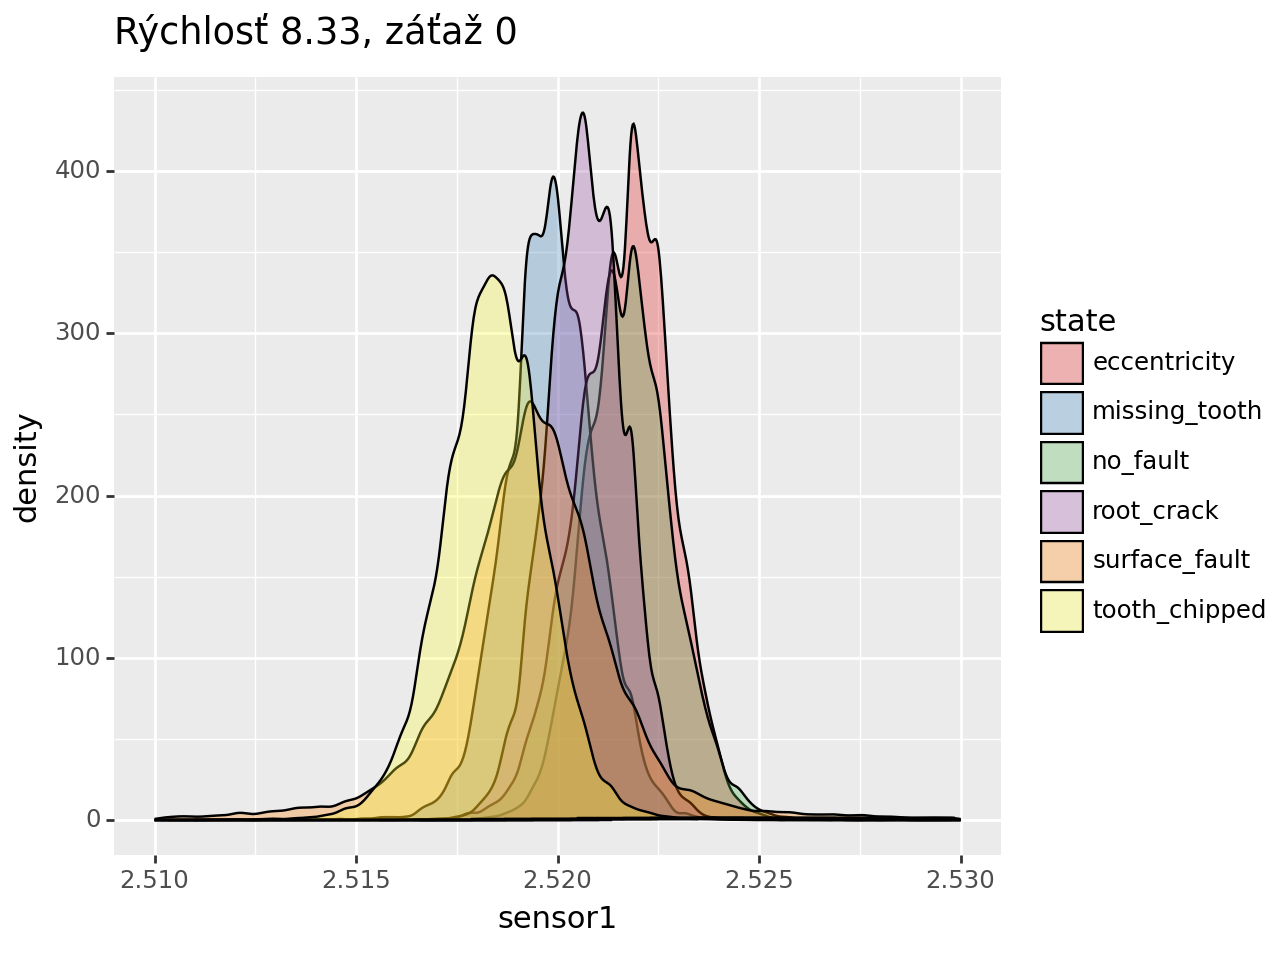

<Figure Size: (640 x 480)>

"\ndisplay(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.5, 2.535))\ndisplay(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.45, 2.59))\ndisplay(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.41, 2.61))\ndisplay(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0') + xlim(2.45, 2.57))\ndisplay(ggplot(data = speedload_40_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_

In [69]:
speedload_8_0 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity']) 
                        & (df.speedSet == 8.33203125) & (df.load_value == 0)].copy()
speedload_8_80 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity']) 
                        & (df.speedSet == 8.33203125) & (df.load_value == 80)].copy()
speedload_25_0 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'])
                        & (df.speedSet == 25) & (df.load_value == 0)].copy()
speedload_25_80 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'])       
                        & (df.speedSet == 25) & (df.load_value == 80)].copy()
speedload_40_0 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'])
                        & (df.speedSet == 40) & (df.load_value == 0)].copy()
speedload_40_80 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'])
                        & (df.speedSet == 40) & (df.load_value == 80)].copy()

# Define your custom color palette
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']
        
display(ggplot(data = speedload_8_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 0') + xlim(2.51, 2.53))
"""
display(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.5, 2.535))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.45, 2.59))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.41, 2.61))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0') + xlim(2.45, 2.57))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80') + xlim(2.4, 2.62))
# I need to narrow the x-axis range to see the differences better

display(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80'))
"""


c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 300 rows containing non-finite values.
c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 300 rows containing non-finite values.


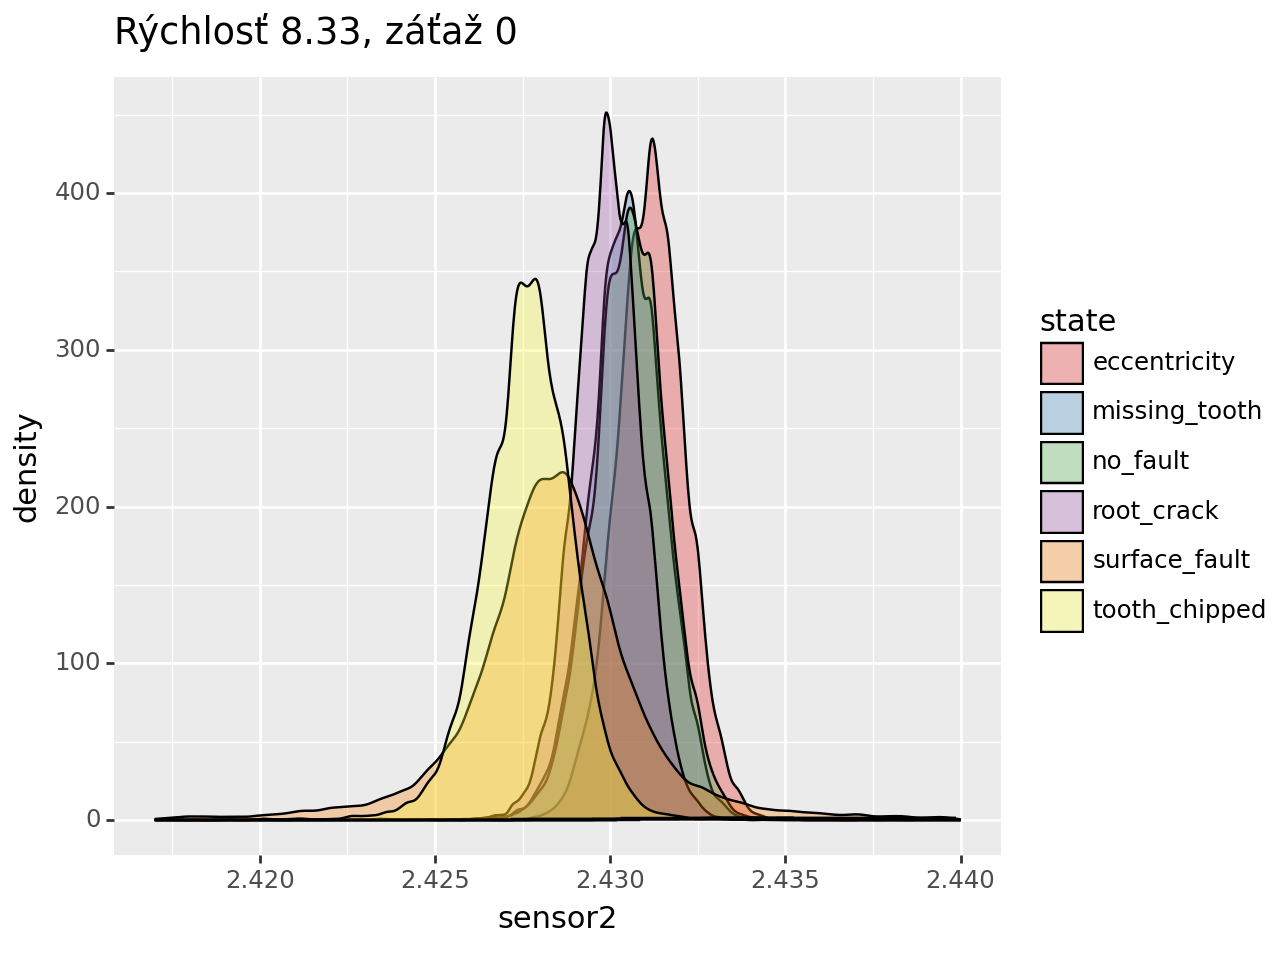

<Figure Size: (640 x 480)>

"\ndisplay(ggplot(data=speedload_8_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.417, 2.44))\ndisplay(ggplot(data=speedload_25_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.4, 2.45))\ndisplay(ggplot(data=speedload_25_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.4, 2.45))\ndisplay(ggplot(data=speedload_40_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0') + xlim(2.4, 2.45))\ndisplay(ggplot(data=speedload_40_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_

In [70]:

display(ggplot(data=speedload_8_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() + 
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 0') + xlim(2.417, 2.44))
"""
display(ggplot(data=speedload_8_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.417, 2.44))
display(ggplot(data=speedload_25_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.4, 2.45))
display(ggplot(data=speedload_25_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.4, 2.45))
display(ggplot(data=speedload_40_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0') + xlim(2.4, 2.45))
display(ggplot(data=speedload_40_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80') + xlim(2.37, 2.55))

display(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80'))
"""

In [71]:
df.describe()

,sensor1,sensor2,time_x,speedSet,load_value,time_normalized,time_formatted,sensor1_max_exp,sensor1_min_exp,sensor2_max_exp,sensor2_min_exp,sensor1_mean_exp,sensor2_mean_exp,sensor1_std_exp,sensor2_std_exp
count,900000.000000,900000.000000,900000,900000.000000,900000.000000,900000.000000,900000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,899964.000000,899964.000000
mean,2.519877,2.429291,2023-05-03 13:39:41.138789376,24.444010,40.000000,2.499900,2023-05-03 13:39:41.138789376,2.573781,2.469107,2.479458,2.379465,2.519877,2.429305,0.007701,0.007624
min,2.219428,2.161939,2023-05-02 10:30:01,8.332031,0.000000,0.000000,2023-05-02 10:30:01,2.505397,2.219428,2.370050,2.161939,2.505397,2.370050,0.000000,0.000116
25%,2.516895,2.426390,2023-05-02 16:02:08.249949952,8.332031,0.000000,1.249950,2023-05-02 16:02:08.249949952,2.530364,2.471067,2.444622,2.381219,2.518606,2.427801,0.001773,0.001572
50%,2.520180,2.429839,2023-05-03 13:54:29.499899904,25.000000,40.000000,2.499900,2023-05-03 13:54:29.499899904,2.550403,2.489792,2.455134,2.402737,2.520002,2.429890,0.005776,0.005835
75%,2.522972,2.432303,2023-05-03 20:28:31.249850112,40.000000,80.000000,3.749850,2023-05-03 20:28:31.249850112,2.573399,2.509339,2.485522,2.415713,2.521257,2.430585,0.009129,0.008702
max,2.820934,2.709896,2023-05-07 17:11:48.999800,40.000000,80.000000,4.999800,2023-05-07 17:11:48.999800,2.820934,2.530856,2.709896,2.442979,2.537755,2.459569,0.040535,0.061190
std,0.011236,0.012001,NaN,12.934378,40.000022,1.443376,NaN,0.073389,0.066855,0.060578,0.059966,0.001592,0.001854,0.007568,0.008473


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   sensor1           900000 non-null  float64       
 1   sensor2           900000 non-null  float64       
 2   time_x            900000 non-null  datetime64[ns]
 3   speedSet          900000 non-null  float64       
 4   load_value        900000 non-null  int64         
 5   gear_fault_desc   900000 non-null  object        
 6   state             900000 non-null  object        
 7   time_normalized   900000 non-null  float64       
 8   time_formatted    900000 non-null  datetime64[ns]
 9   no_fault          900000 non-null  bool          
 10  sensor1_max_exp   900000 non-null  float64       
 11  sensor1_min_exp   900000 non-null  float64       
 12  sensor2_max_exp   900000 non-null  float64       
 13  sensor2_min_exp   900000 non-null  float64       
 14  sensor1_m

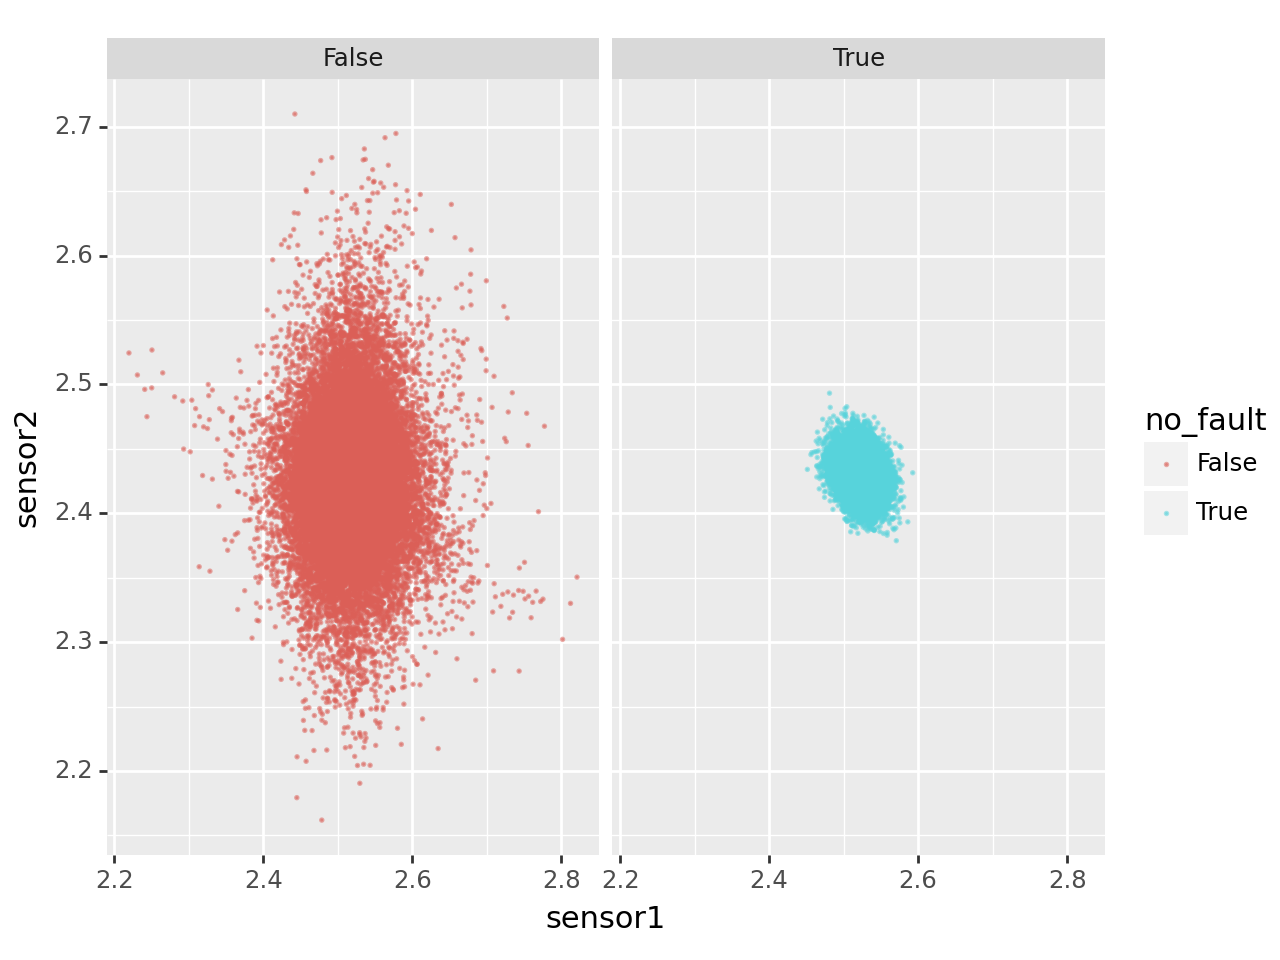

<Figure Size: (640 x 480)>

c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 36 rows containing missing values.


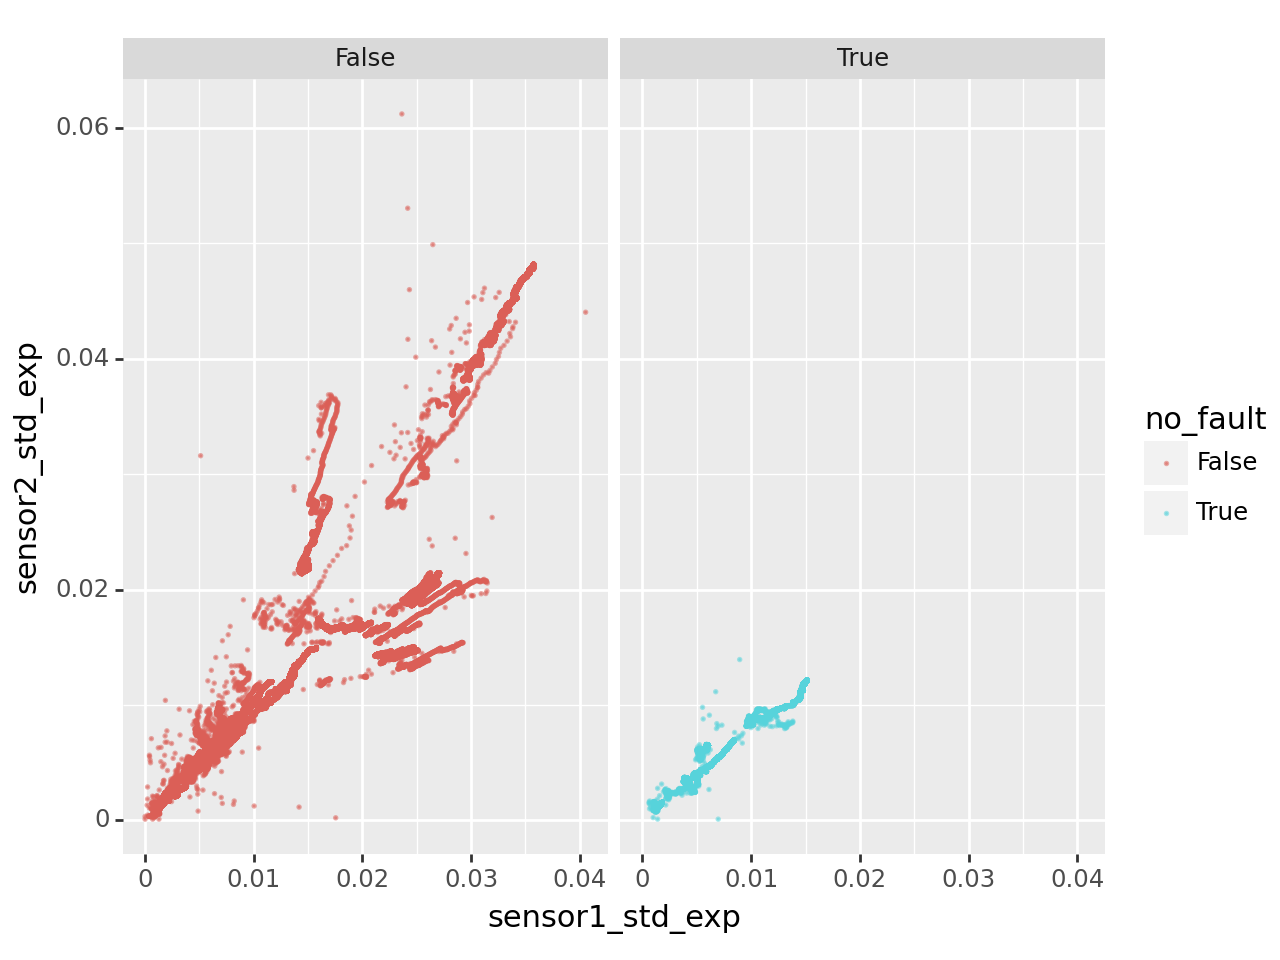

<Figure Size: (640 x 480)>

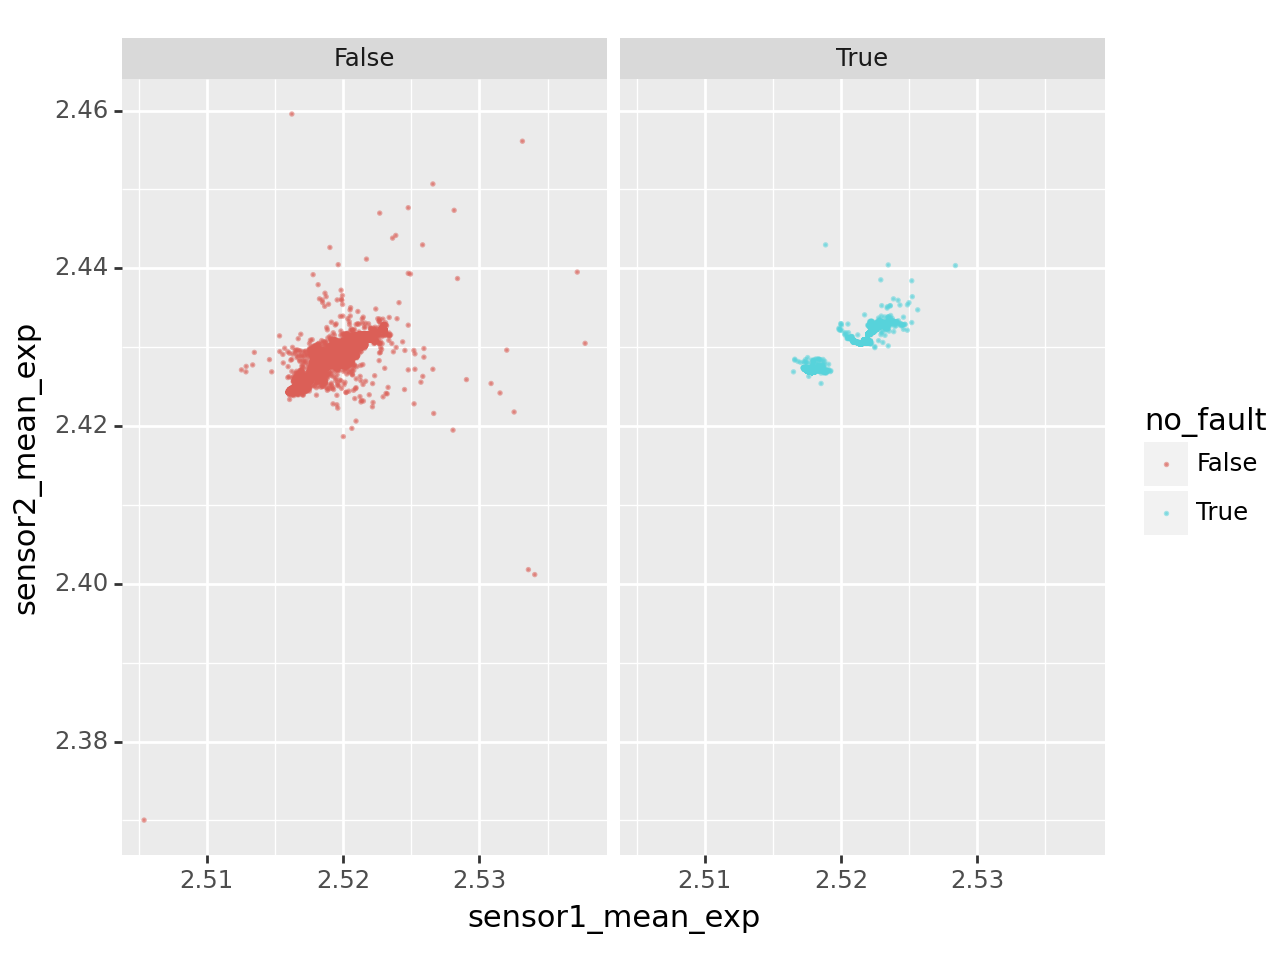

<Figure Size: (640 x 480)>

In [73]:
display(ggplot(data = df, mapping = aes(x = 'sensor1', y = 'sensor2', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))
display(ggplot(data = df, mapping = aes(x = 'sensor1_std_exp', y = 'sensor2_std_exp', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))
display(ggplot(data = df, mapping = aes(x = 'sensor1_mean_exp', y = 'sensor2_mean_exp', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))

In [74]:
"""
# Save DataFrames to an HDF5 file
with pd.HDFStore('speedload_data.h5', mode='w') as store:
    store.put('speedload_8_0', speedload_8_0, format='table')
    store.put('speedload_8_80', speedload_8_80, format='table')
    store.put('speedload_25_0', speedload_25_0, format='table')
    store.put('speedload_25_80', speedload_25_80, format='table')
    store.put('speedload_40_0', speedload_40_0, format='table')
    store.put('speedload_40_80', speedload_40_80, format='table')
"""

"\n# Save DataFrames to an HDF5 file\nwith pd.HDFStore('speedload_data.h5', mode='w') as store:\n    store.put('speedload_8_0', speedload_8_0, format='table')\n    store.put('speedload_8_80', speedload_8_80, format='table')\n    store.put('speedload_25_0', speedload_25_0, format='table')\n    store.put('speedload_25_80', speedload_25_80, format='table')\n    store.put('speedload_40_0', speedload_40_0, format='table')\n    store.put('speedload_40_80', speedload_40_80, format='table')\n"

In [75]:
# Find NaN values and replace with 0
df.fillna(0, inplace=True)
df.isna().sum()

sensor1             0
sensor2             0
time_x              0
speedSet            0
load_value          0
gear_fault_desc     0
state               0
time_normalized     0
time_formatted      0
no_fault            0
sensor1_max_exp     0
sensor1_min_exp     0
sensor2_max_exp     0
sensor2_min_exp     0
sensor1_mean_exp    0
sensor2_mean_exp    0
sensor1_std_exp     0
sensor2_std_exp     0
dtype: int64

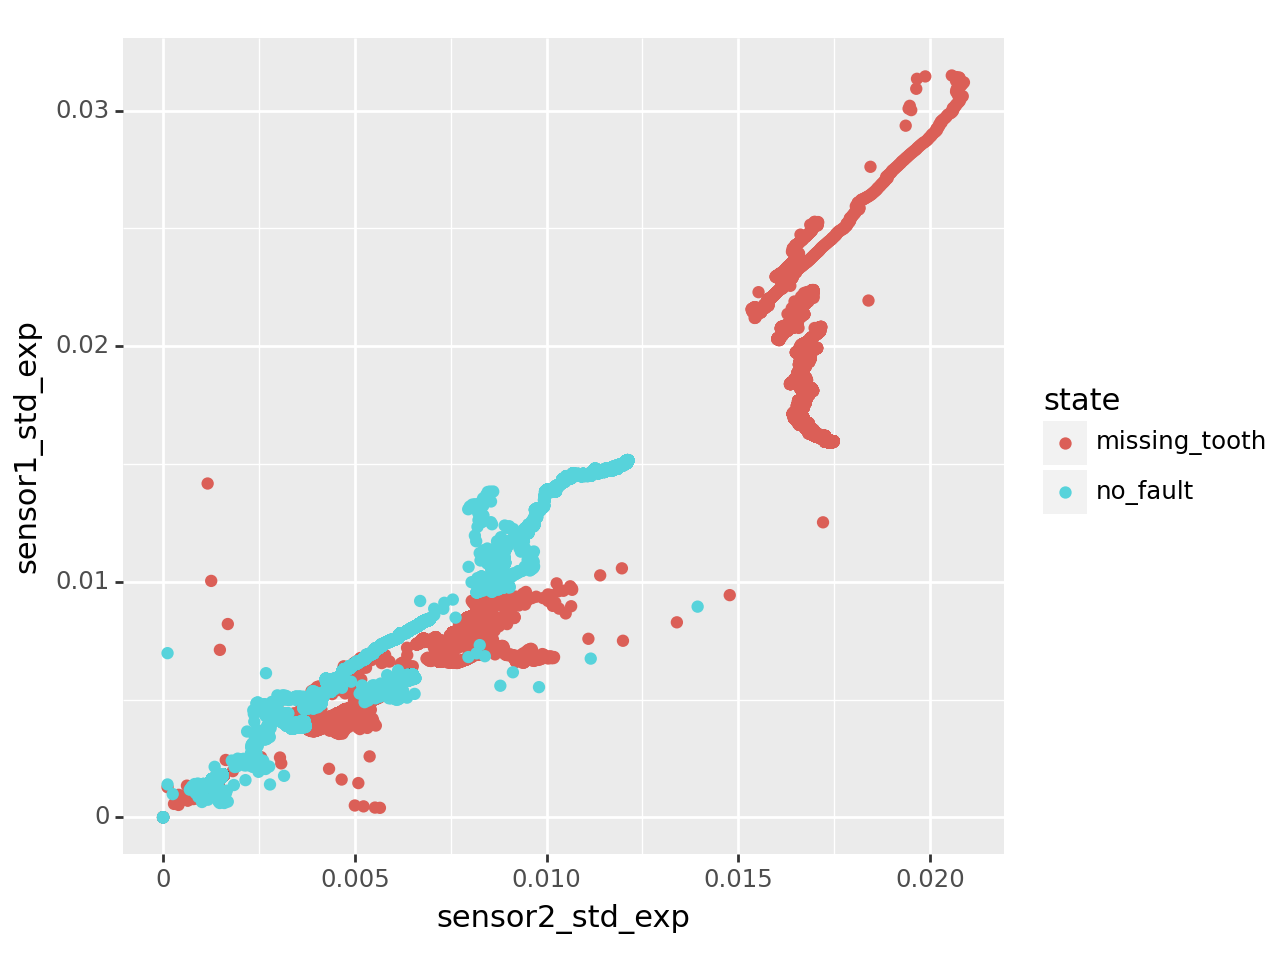

<Figure Size: (640 x 480)>

"\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'tooth_chipped'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'surface_fault'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'root_crack'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'eccentricity'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\n"

In [76]:
# Create the graph above only with no_fault vs other states
display(ggplot(data = df[df.state.isin(['no_fault', 'missing_tooth'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
"""
display(ggplot(data = df[df.state.isin(['no_fault', 'tooth_chipped'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'surface_fault'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'root_crack'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'eccentricity'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
"""

In [77]:
# Create a formated column of state as Expected: [0 1 2 3 4 5] input
display(df.state.unique())
df['state_expected'] = df.state.apply(lambda x: ['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'].index(x))
# Create a df dataset that excludes time_x, gear_fault_desc, state, time_formatted
df_edit = df[['sensor1', 'sensor2', 'sensor1_max_exp', 'sensor1_min_exp', 'sensor1_mean_exp', 'sensor1_std_exp', 
        'sensor2_max_exp', 'sensor2_min_exp', 'sensor2_mean_exp', 'sensor2_std_exp', 'speedSet', 'load_value', 'state_expected', 'time_normalized']]
display(df.state_expected.unique())


array(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault',
       'root_crack', 'eccentricity'], dtype=object)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [78]:
df_edit.head()

,sensor1,sensor2,sensor1_max_exp,sensor1_min_exp,sensor1_mean_exp,sensor1_std_exp,sensor2_max_exp,sensor2_min_exp,sensor2_mean_exp,sensor2_std_exp,speedSet,load_value,state_expected,time_normalized
0,2.520016,2.430496,2.520016,2.520016,2.520016,0.000000,2.430496,2.430496,2.430496,0.000000,8.332031,0,0,0.0000
1,2.521822,2.430660,2.521822,2.520016,2.520919,0.001278,2.430660,2.430496,2.430578,0.000116,8.332031,0,0,0.0002
2,2.519194,2.429511,2.521822,2.519194,2.520344,0.001344,2.430660,2.429511,2.430222,0.000622,8.332031,0,0,0.0004
3,2.519851,2.428853,2.521822,2.519194,2.520221,0.001125,2.430660,2.428853,2.429880,0.000852,8.332031,0,0,0.0006
4,2.518701,2.429346,2.521822,2.518701,2.519917,0.001188,2.430660,2.428853,2.429773,0.000776,8.332031,0,0,0.0008


In [79]:
# Logistic Regression with cross-validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

X = df_edit.drop('state_expected', axis=1)
y = df_edit.state_expected

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# Reorder by time_normalized


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=100, multi_class='ovr', C=0.1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

# Cross-validation
#cv_scores = cross_val_score(log_reg, X, y, cv=10)
#display(cv_scores)


c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy:  0.8072277777777778
Confusion Matrix: 
 [[29510   420     0     5    57     8]
 [   39 27280    26   490  2094    71]
 [    5    14 29886    21    65     9]
 [    7  6959     0  9088   897 13049]
 [    2   190     0  5522 24185   101]
 [    3     2     0   267  4376 25352]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     30000
           1       0.78      0.91      0.84     30000
           2       1.00      1.00      1.00     30000
           3       0.59      0.30      0.40     30000
           4       0.76      0.81      0.78     30000
           5       0.66      0.85      0.74     30000

    accuracy                           0.81    180000
   macro avg       0.80      0.81      0.79    180000
weighted avg       0.80      0.81      0.79    180000



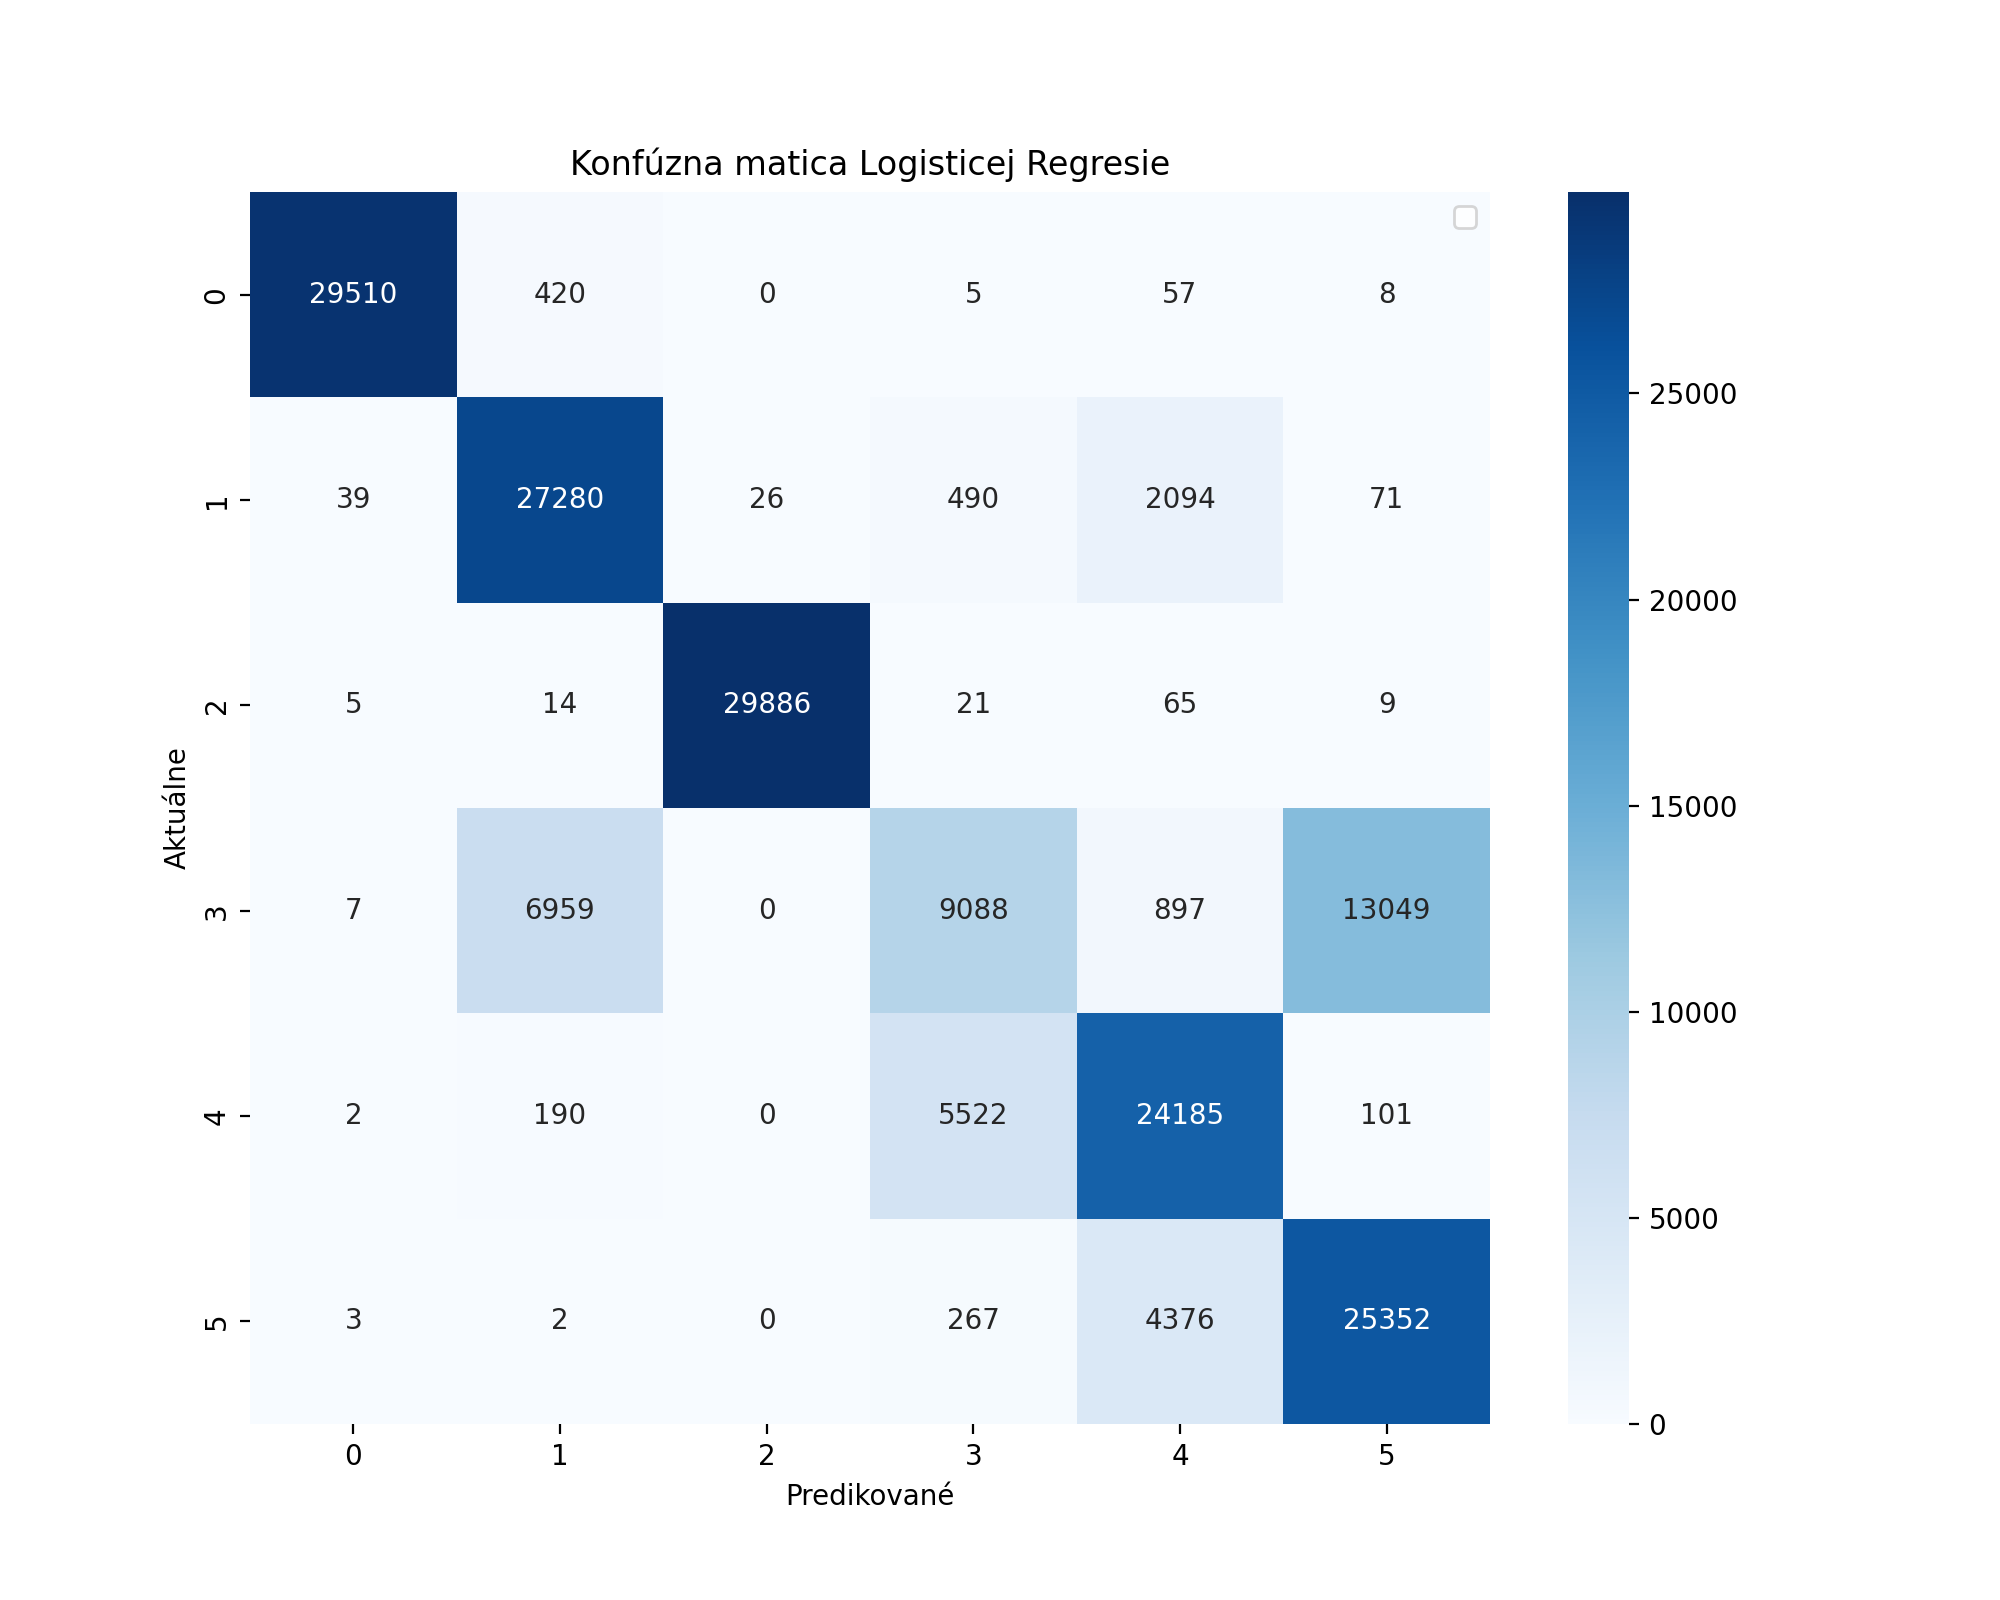

In [80]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# Calculate accuracy
accuracy = np.trace(cm) / np.sum(cm)
# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title('Konfúzna matica Logisticej Regresie')
plt.legend([f'Presnosť: {accuracy:.2f}'])
plt.show()


In [81]:
# Logistic Regression with cross-validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


# X should include only sensor1, sensor2, sensor1_max_exp, speedSet, load_value
X = df_edit[['sensor1', 'sensor2', 'speedSet', 'load_value', 'time_normalized', 'sensor1_std_exp', 'sensor2_std_exp']]
y = df_edit.state_expected

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=100, multi_class='ovr', C=0.1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

# Cross-validation
#cv_scores = cross_val_score(log_reg, X, y, cv=10)
#display(cv_scores)

Accuracy:  0.00020555555555555556
Confusion Matrix: 
 [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [14036 10402     0  5525    37     0]
 [17800 34800     1 38616 58783     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00     30000
           5       0.00      0.00      0.00    150000

    accuracy                           0.00    180000
   macro avg       0.00      0.00      0.00    180000
weighted avg       0.00      0.00      0.00    180000



c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Reca

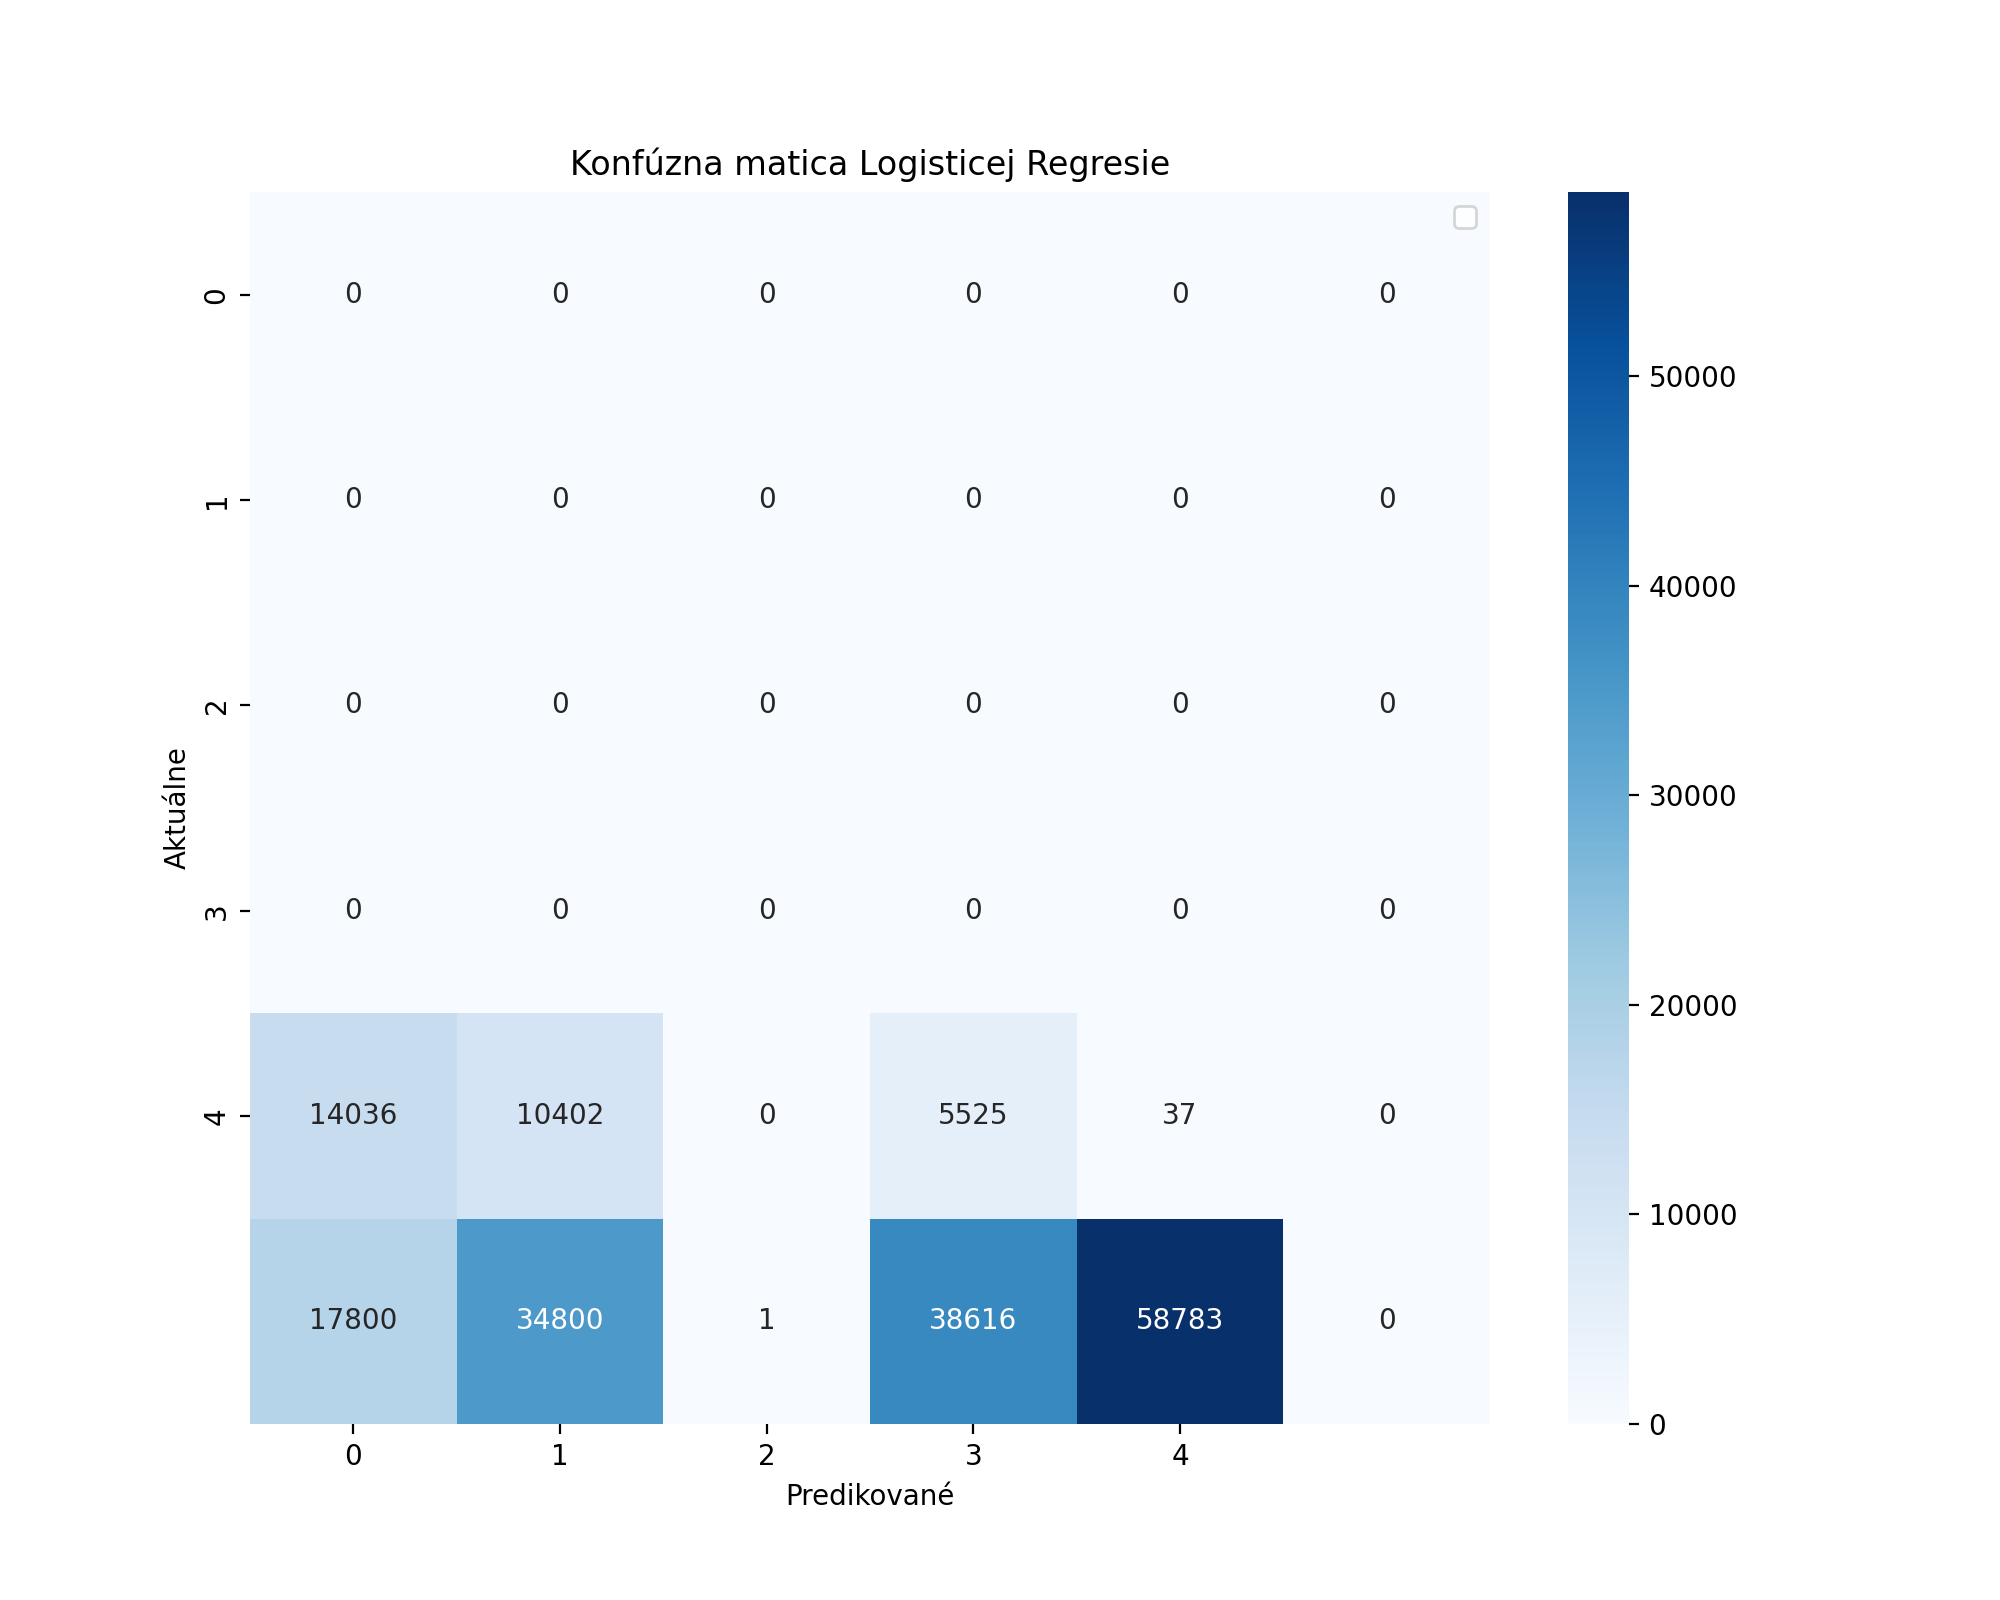

In [82]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# Calculate accuracy
accuracy = np.trace(cm) / np.sum(cm)
# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title('Konfúzna matica Logisticej Regresie')
plt.legend([f'Presnosť: {accuracy:.2f}'])
plt.show()

In [83]:
print(df_edit.head(-5))

         sensor1   sensor2  sensor1_max_exp  sensor1_min_exp  \
0       2.520016  2.430496         2.520016         2.520016   
1       2.521822  2.430660         2.521822         2.520016   
2       2.519194  2.429511         2.521822         2.519194   
3       2.519851  2.428853         2.521822         2.519194   
4       2.518701  2.429346         2.521822         2.518701   
...          ...       ...              ...              ...   
149990  2.527407  2.439037         2.564200         2.467454   
149991  2.526093  2.415056         2.564200         2.467454   
149992  2.544654  2.423269         2.564200         2.467454   
149993  2.524779  2.430825         2.564200         2.467454   
149994  2.502276  2.436409         2.564200         2.467454   

        sensor1_mean_exp  sensor1_std_exp  sensor2_max_exp  sensor2_min_exp  \
0               2.520016         0.000000         2.430496         2.430496   
1               2.520919         0.001278         2.430660         2.4304

In [84]:
print(df_edit.state_expected.unique())
# Split df_edit into 99.98 train and 0.01 test and 0.01 validation data and pick the end of time series stratified by state_expected
X = df_edit[['sensor1', 'sensor2', 'speedSet', 'load_value', 'time_normalized']]
y = df_edit.state_expected

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)
# Calculate min max std mean for sensor1 and sensor2 for train, test and validation data separately
X_train['sensor1_max'] = X_train['sensor1'].max()
X_train['sensor1_min'] = X_train['sensor1'].min()
X_train['sensor1_std'] = X_train['sensor1'].std()
X_train['sensor1_mean'] = X_train['sensor1'].mean()
X_train['sensor2_max'] = X_train['sensor2'].max()
X_train['sensor2_min'] = X_train['sensor2'].min()
X_train['sensor2_std'] = X_train['sensor2'].std()
X_train['sensor2_mean'] = X_train['sensor2'].mean()

X_test['sensor1_max'] = X_test['sensor1'].max()
X_test['sensor1_min'] = X_test['sensor1'].min()
X_test['sensor1_std'] = X_test['sensor1'].std()
X_test['sensor1_mean'] = X_test['sensor1'].mean()
X_test['sensor2_max'] = X_test['sensor2'].max()
X_test['sensor2_min'] = X_test['sensor2'].min()
X_test['sensor2_std'] = X_test['sensor2'].std()
X_test['sensor2_mean'] = X_test['sensor2'].mean()

X_val['sensor1_max'] = X_val['sensor1'].max()
X_val['sensor1_min'] = X_val['sensor1'].min()
X_val['sensor1_std'] = X_val['sensor1'].std()
X_val['sensor1_mean'] = X_val['sensor1'].mean()
X_val['sensor2_max'] = X_val['sensor2'].max()
X_val['sensor2_min'] = X_val['sensor2'].min()
X_val['sensor2_std'] = X_val['sensor2'].std()
X_val['sensor2_mean'] = X_val['sensor2'].mean()

print(y_val.value_counts())
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

log_reg = LogisticRegression(max_iter=100, multi_class='ovr', C=0.1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))


[0 1 2 3 4 5]
state_expected
5    12000
3    12000
0    12000
2    12000
1    12000
4    12000
Name: count, dtype: int64
Accuracy:  0.23066111111111112


In [85]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Create a Lightgbm model for classification using the df dataset print the accuracy of the model

X = df_edit[['sensor1', 'sensor2', 'speedSet','time_normalized', 'load_value', 'sensor2_std_exp', 'sensor1_std_exp']]
             #'sensor1_max_exp', 'sensor1_min_exp', 'sensor1_mean_exp', 'sensor1_std_exp', 'sensor2_max_exp', 'sensor2_min_exp', 'sensor2_mean_exp', 'sensor2_std_exp']]
y = df_edit['state_expected']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)
display(X_train)
display(X_test)
# Create the LightGBM classifier
clf = lgb.LGBMClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

,sensor1,sensor2,speedSet,time_normalized,load_value,sensor2_std_exp,sensor1_std_exp
90681,2.517880,2.431646,25.000000,3.1362,80,0.006586,0.008101
17249,2.522644,2.429839,8.332031,3.4498,0,0.000945,0.000947
36325,2.520508,2.431317,8.332031,2.2650,80,0.001534,0.001740
130601,2.522644,2.420641,40.000000,1.1202,80,0.011752,0.014840
74803,2.515909,2.422612,25.000000,4.9606,0,0.003639,0.003918
...,...,...,...,...,...,...,...
16197,2.521165,2.431646,8.332031,3.2394,0,0.000973,0.001027
80508,2.528393,2.429511,25.000000,1.1016,80,0.005912,0.006818
20404,2.518866,2.427375,8.332031,4.0808,0,0.001290,0.001253
132182,2.524943,2.436574,40.000000,1.4364,80,0.011815,0.014808


,sensor1,sensor2,speedSet,time_normalized,load_value,sensor2_std_exp,sensor1_std_exp
133817,2.509010,2.442815,40.000000,1.7634,80,0.011865,0.014895
116568,2.513117,2.425568,40.000000,3.3136,0,0.006287,0.005754
88943,2.492092,2.430003,25.000000,2.7886,80,0.020336,0.026125
112682,2.516566,2.408486,40.000000,2.5364,0,0.021950,0.015026
114426,2.520016,2.406186,40.000000,2.8852,0,0.022022,0.014981
...,...,...,...,...,...,...,...
18995,2.521330,2.430825,8.332031,3.7990,0,0.001039,0.001160
149274,2.536605,2.439530,40.000000,4.8548,80,0.014932,0.015724
119130,2.509667,2.431810,40.000000,3.8260,0,0.006277,0.005750
16395,2.523465,2.431810,8.332031,3.2790,0,0.000972,0.001026


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 648000, number of used features: 7
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
Accuracy: 0.9984444444444445


In [91]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Create a Lightgbm model for classification using the df dataset print the accuracy of the model
X = df_edit[['sensor1', 'sensor2', 'speedSet', 'load_value', 'time_normalized']]
y = df_edit['state_expected']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)
# Add column y_to train test val
"""
# Calculate min max std mean for sensor1 and sensor2 for train, test and validation data separately
X_train['sensor1_max'] = X_train['sensor1'].max()
X_train['sensor1_min'] = X_train['sensor1'].min()
X_train['sensor1_mean'] = X_train['sensor1'].mean()
X_train['sensor2_max'] = X_train['sensor2'].max()
X_train['sensor2_min'] = X_train['sensor2'].min()
X_train['sensor2_mean'] = X_train['sensor2'].mean()
"""
X_train['sensor1_std_exp'] = X_train.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().std())
X_train['sensor2_std_exp'] = X_train.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().std())
"""
X_test['sensor1_max'] = X_test['sensor1'].max()
X_test['sensor1_min'] = X_test['sensor1'].min()
X_test['sensor1_mean'] = X_test['sensor1'].mean()
X_test['sensor2_max'] = X_test['sensor2'].max()
X_test['sensor2_min'] = X_test['sensor2'].min()
X_test['sensor2_mean'] = X_test['sensor2'].mean()
"""
X_test['sensor1_std_exp'] = X_test.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().std())
X_test['sensor1_std_exp'] = X_test.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().std())
"""
X_val['sensor1_max'] = X_val['sensor1'].max()
X_val['sensor1_min'] = X_val['sensor1'].min()
X_val['sensor1_mean'] = X_val['sensor1'].mean()
X_val['sensor2_max'] = X_val['sensor2'].max()
X_val['sensor2_min'] = X_val['sensor2'].min()
X_val['sensor2_mean'] = X_val['sensor2'].mean()
"""
X_val['sensor1_std_exp'] = X_val.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().std())
X_val['sensor1_std_exp'] = X_val.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().std())

# Drop column state and change new y order

display(X_train)
display(X_test)

print(y_val.value_counts())
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Create the LightGBM classifier
clf = lgb.LGBMClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

KeyError: 'state'

In [ ]:
"""
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title('Konfúzna matica LightGBM')
plt.legend([f'Presnosť: {accuracy:.2f}'])
plt.show()
"""


"\nfrom sklearn.metrics import confusion_matrix\nimport matplotlib.pyplot as plt\n\n# Calculate the confusion matrix\ncm = confusion_matrix(y_test, y_pred)\n\n# Show confnusion matrix as a heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)\nplt.xlabel('Predikované')\nplt.ylabel('Aktuálne')\nplt.title('Konfúzna matica LightGBM')\nplt.legend([f'Presnosť: {accuracy:.2f}'])\nplt.show()\n"

In [ ]:
"""
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Create a Xgboost model for classification using the df dataset print the accuracy of the model

# Split the dataset into features (X) and target variable (y)
X = df_edit.drop(['state_expected'], axis=1)
y = df_edit['state_expected']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier model
model = xgb.XGBClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
"""

'\nimport xgboost as xgb\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n# Create a Xgboost model for classification using the df dataset print the accuracy of the model\n\n# Split the dataset into features (X) and target variable (y)\nX = df_edit.drop([\'state_expected\'], axis=1)\ny = df_edit[\'state_expected\']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create the XGBoost classifier model\nmodel = xgb.XGBClassifier()\n\n# Fit the model on the training data\nmodel.fit(X_train, y_train)\n\n# Make predictions on the testing data\ny_pred = model.predict(X_test)\n\n# Calculate the accuracy of the model\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n'

In [ ]:
"""
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix  XGBoost')
plt.show()
"""



"\n# Calculate the confusion matrix\ncm = confusion_matrix(y_test, y_pred)\n\n# Show confnusion matrix as a heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix  XGBoost')\nplt.show()\n"

In [ ]:
"""
# Create a multilayer perceptron model for classification using the df dataset print the accuracy of the model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into features (X) and target variable (y)
X = df_edit.drop(['state_expected'], axis=1)
y = df_edit['state_expected']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the MLP classifier model
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
"""


'\n# Create a multilayer perceptron model for classification using the df dataset print the accuracy of the model\nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Split the dataset into features (X) and target variable (y)\nX = df_edit.drop([\'state_expected\'], axis=1)\ny = df_edit[\'state_expected\']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create the MLP classifier model\nmodel = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)\n\n# Fit the model on the training data\nmodel.fit(X_train, y_train)\n\n# Make predictions on the testing data\ny_pred = model.predict(X_test)\n\n# Calculate the accuracy of the model\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n'

In [ ]:
"""
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix  MLP')
plt.show()
"""

"\n# Calculate the confusion matrix\ncm = confusion_matrix(y_test, y_pred)\n\n# Show confnusion matrix as a heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix  MLP')\nplt.show()\n"

In [ ]:
"""
# Create a KNN model for classification using the df dataset print the accuracy of the model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into features (X) and target variable (y)
X = df_edit.drop(['state_expected'], axis=1)
y = df_edit['state_expected']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the KNN classifier model
model = KNeighborsClassifier(n_neighbors=3)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)


# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
"""


'\n# Create a KNN model for classification using the df dataset print the accuracy of the model\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Split the dataset into features (X) and target variable (y)\nX = df_edit.drop([\'state_expected\'], axis=1)\ny = df_edit[\'state_expected\']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create the KNN classifier model\nmodel = KNeighborsClassifier(n_neighbors=3)\n\n# Fit the model on the training data\nmodel.fit(X_train, y_train)\n\n# Make predictions on the testing data\ny_pred = model.predict(X_test)\n\n\n# Calculate the accuracy of the model\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n'

In [ ]:
"""
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix  KNN')
plt.show()
"""


"\n# Calculate the confusion matrix\ncm = confusion_matrix(y_test, y_pred)\n\n# Show confnusion matrix as a heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix  KNN')\nplt.show()\n"

In [ ]:
"""
# Create a Random forest model for classification using the df dataset print the accuracy of the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into features (X) and target variable (y)
X = df_edit.drop(['state_expected'], axis=1)
y = df_edit['state_expected']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest classifier model
model = RandomForestClassifier(n_estimators=100)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
"""


'\n# Create a Random forest model for classification using the df dataset print the accuracy of the model\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Split the dataset into features (X) and target variable (y)\nX = df_edit.drop([\'state_expected\'], axis=1)\ny = df_edit[\'state_expected\']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create the Random Forest classifier model\nmodel = RandomForestClassifier(n_estimators=100)\n\n# Fit the model on the training data\nmodel.fit(X_train, y_train)\n\n# Make predictions on the testing data\ny_pred = model.predict(X_test)\n\n# Calculate the accuracy of the model\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n'

In [ ]:
"""
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest"')
plt.show()
"""

'\n# Calculate the confusion matrix\ncm = confusion_matrix(y_test, y_pred)\n\n# Show confnusion matrix as a heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues\', xticklabels=model.classes_, yticklabels=model.classes_)\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\nplt.title(\'Confusion Matrix Random Forest"\')\nplt.show()\n'

In [ ]:
# Create a decision tree model for classification using the df dataset print the accuracy of the model


In [ ]:
"""
from sklearn.svm import SVC

# Create the SVM classifier
clf = SVC()

X = df[['sensor1', 'sensor2', 'sensor1_max_exp', 'sensor1_min_exp', 'sensor1_mean_exp',
        'sensor2_max_exp', 'sensor2_min_exp', 'sensor2_mean_exp', 'speedSet', 'load_value']]
y = df['state']

# Fit the classifier to the data
clf.fit(X, y)

# Print the accuracy of the classifier
print(clf.score(X, y))
"""

"\nfrom sklearn.svm import SVC\n\n# Create the SVM classifier\nclf = SVC()\n\nX = df[['sensor1', 'sensor2', 'sensor1_max_exp', 'sensor1_min_exp', 'sensor1_mean_exp',\n        'sensor2_max_exp', 'sensor2_min_exp', 'sensor2_mean_exp', 'speedSet', 'load_value']]\ny = df['state']\n\n# Fit the classifier to the data\nclf.fit(X, y)\n\n# Print the accuracy of the classifier\nprint(clf.score(X, y))\n"